In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim 
import torchvision 
import torchvision.transforms as transforms
from datetime import datetime
import pandas as pd
import xgboost as xgb
from xgboost import XGBClassifier
import os
from os.path import join
import timeit
from tqdm import tqdm
import numpy as np
import optuna
from sklearn.metrics import confusion_matrix
from torch.utils.tensorboard import SummaryWriter
torch.cuda.is_available() 
from sklearn.metrics import roc_auc_score

In [2]:
def data_loader(data="train", directory=join(os.getcwd(),'NormalizedData.h5')):
    # Data types = train, validate, test
    print("[+] Loading Data..")
    tic=timeit.default_timer()

    df = pd.read_hdf(
                    directory,
                    key=data,
                    )
    
    toc=timeit.default_timer()
    print("[+] Data Loaded in", int(toc-tic), "seconds!")

    return df

def create_batch(df, size=None, debug=False):
    # Data types = train, validate, test

    if debug:
        print("[Info] Len(data) =", len(df))
        print("[Info] Len(data) / Batch Size =", len(df)/size)

    if size is None:
        size = df.shape[0]

    # Select the data size
    # TODO: Estou a perder um pouco de dados no final
    batch = iter([
            # Big tuple
            (
                i+1, # Batch number
                df.iloc[x:x+size].drop(columns=['index','Name', 'Weights', 'Label']), # Features Removi MissingET_Eta porque tava cheio de NaA (???)
                df['Label'].iloc[x:x+size],

                (
                np.where(
                    df['Label'].iloc[x:x+size] == 0,
                    df['Weights'].iloc[x:x+size] / df['Weights'].iloc[x:x+size][df['Label'].iloc[x:x+size] == 0].sum(),
                    df['Weights'].iloc[x:x+size] / df['Weights'].iloc[x:x+size][df['Label'].iloc[x:x+size] == 1].sum(),
                )
                * df['Label'].iloc[x:x+size].shape[0]
                / 2
                ),
                df.iloc[x:x+size]['Name'] #Nome
        ) 
        
         for i,x in enumerate(list(filter(lambda x: (x%(size+1) == 0) , [x for x in range(len(df))])))]) # Para size = 100 -> 0, 101, 202, 303, .. , 909, 1010, 1111


    del df

    return batch

def bce(y_preds, y_true, epsilon=np.finfo(np.float32).eps):
    return - (1-y_true)* torch.log(1-y_preds+epsilon) - y_true * torch.log(y_preds+epsilon)

## Training the model

In [3]:
#batch_number, features, target, weights, name 
train_data = data_loader(data='train')
val_data = data_loader(data='validate')


_, train_features, train_label, train_weights, _ = next(create_batch(train_data, size=train_data.shape[0]))
_, val_features, val_label, val_weights, _ = next(create_batch(val_data, size=val_data.shape[0]))

del val_data
del train_data

[+] Loading Data..
[+] Data Loaded in 1 seconds!
[+] Loading Data..
[+] Data Loaded in 8 seconds!


In [4]:
global best_roc
best_roc = 0

In [5]:
def define_model(trial):
    # Optuna Stuff
    n_estimators = trial.suggest_int("n_estimators", 5, 300)
    max_depth = trial.suggest_int("max_depth", 1, 25)
    learning_rate = trial.suggest_float("learning_rate", 1e-6, 1e-1, log=True)

    # Defining the model
    model = XGBClassifier(
      n_jobs=-1
    , objective='binary:logistic' # https://xgboost-clone.readthedocs.io/en/latest/parameter.html#learning-task-parameters
    , n_estimators = n_estimators # Number of boosting rounds.
    , max_depth = max_depth # Maximum tree depth for base learners.
    , learning_rate = learning_rate
    , verbosity = 0 #(Silent)
    , tree_method='gpu_hist'
    )
    return model

In [6]:

def train_model(trial):
    global best_roc

    print("[+] Starting training..")
    tic=timeit.default_timer()  

    # Optuna Stuff
    early_stopping_rounds = trial.suggest_int("early_stopping_rounds", 1, 20)

    # Defining the model
    model = define_model(trial)
    
    model.fit(
        train_features
    , train_label
    , sample_weight = train_weights
    , eval_set = [(val_features, val_label)]
    , sample_weight_eval_set = [val_weights]
    , verbose = False
    , early_stopping_rounds = early_stopping_rounds

    )

    # Final do treino
    toc=timeit.default_timer()

    print("[+] Training completed in", int(toc-tic), "seconds!")

    # Roc_score on the validation data
    roc_score = roc_auc_score(val_label, model.predict(val_features), sample_weight=val_weights)

    if roc_score > best_roc:
        best_roc = roc_score

        # Saving the model
        model.save_model("XGBoost.model")


    return roc_auc_score(val_label , model.predict(val_features), sample_weight=val_weights)

In [7]:
    study = optuna.create_study(study_name="Optimizing XGBoost Model", direction="maximize")
    study.optimize(train_model, n_trials=100)#, timeout=3600)

    pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
    complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

m
[+] Starting training..
[+] Training completed in 91 seconds!
[I 2021-02-17 12:26:01,989] Trial 39 finished with value: 0.8993966987370483 and parameters: {'early_stopping_rounds': 12, 'n_estimators': 212, 'max_depth': 14, 'learning_rate': 0.04091664245382413}. Best is trial 32 with value: 0.9010040722973949.
[+] Starting training..
[+] Training completed in 119 seconds!
[I 2021-02-17 12:28:12,103] Trial 40 finished with value: 0.8844124081325271 and parameters: {'early_stopping_rounds': 4, 'n_estimators': 219, 'max_depth': 14, 'learning_rate': 0.003695229759474092}. Best is trial 32 with value: 0.9010040722973949.
[+] Starting training..
[+] Training completed in 49 seconds!
[I 2021-02-17 12:29:08,296] Trial 41 finished with value: 0.9024637540758014 and parameters: {'early_stopping_rounds': 12, 'n_estimators': 206, 'max_depth': 10, 'learning_rate': 0.04146681807561103}. Best is trial 41 with value: 0.9024637540758014.
[+] Starting training..
[+] Training completed in 39 seconds!
[I

In [8]:
# Saving Study
import joblib
joblib.dump(study, "study_xgboost.pkl")

['study_xgboost.pkl']

## Optuna graphs

In [9]:
import joblib
study = joblib.load("study_xgboost.pkl")

In [10]:
optuna.visualization.plot_param_importances(study)

In [11]:
optuna.visualization.plot_optimization_history(study)

## Testing the model

In [12]:
model = define_model(trial)

In [13]:
model.load_model("XGBoost.model")

In [14]:
# Loading test data
_, test_features, test_label, test_weights, _ = next(create_batch(data_loader(data='test')))

# Passar a matriz
#test = xgb.DMatrix(test_features)


[+] Loading Data..
[+] Data Loaded in 8 seconds!


In [15]:
# Predictions

predictions = model.predict(test_features)#.predict_proba(test_features)

In [16]:
predictions

array([0, 0, 0, ..., 0, 0, 0])

In [17]:
confusion_matrix(predictions, test_label)

array([[1362011,    8847],
       [  81283,   57731]])

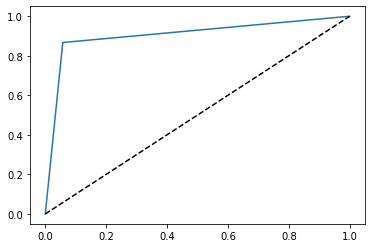

In [18]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# fpr = False positive rate
# tpr = True positive rate
fpr, tpr, thr = roc_curve(test_label , predictions, sample_weight=test_weights)
plt.plot(fpr, tpr, label='ROC')
plt.plot([0,1],[0,1], 'k--')
plt.show()

In [19]:
roc_auc_score(test_label , predictions, sample_weight=test_weights)

0.9048451689102053

0.8715906 antes da optimização do optuna ||
0.9048451689102053 depois da optimização do optuna